# PRIMERA PARTE DEL EDA

## Primera exploracion de los datos

In [9]:
# Librerias 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from PIL import Image 
import os 
import random

from skimpy import skim  # Es como un describe pero mucho mas ordenado y con mas informacion 


1) Cargado del fichero inicial

In [2]:
photos = pd.read_json("photos.json", lines=True)
photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


In [10]:
# Skim output 
skim(photos)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 200100 │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 4      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ photo_id                  │       0 │          0 │                            1 │                   200100 │  │
│ │ business_id               │       0 │          0 │                            1 │                   200100 │  │
│ │ caption                   │       0 │          0 │                            3 │                   610159 │  │
│ │ label                     │       0 │          0 │                            1 │                   200100 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

2) Distribucion de muestras por "label" del conjunto de datos completo (incluye imagenes corruptas)

In [3]:
# Muestras de cada tipo de fotografia 
photos["label"].value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

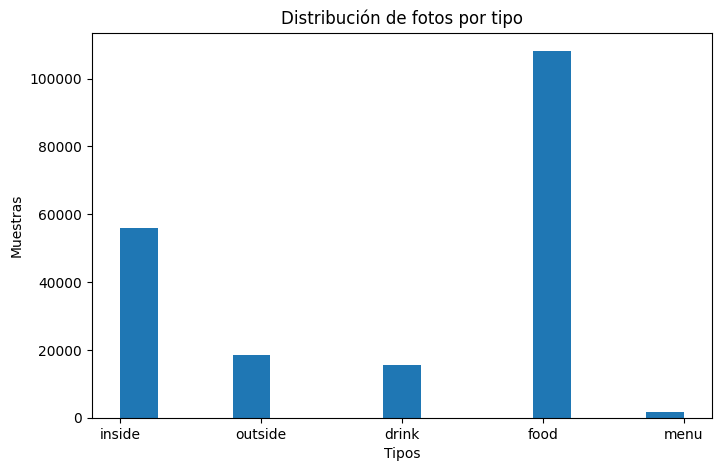

In [4]:
# Plot de distribucion 
plt.figure(figsize=(8,5))
plt.title("Distribución de fotos por tipo")
plt.hist(x = photos["label"], bins=15)
plt.xlabel("Tipos")
plt.ylabel("Muestras")
plt.show()

3) Funcion que cuenta el numero de imagenes en un documento -> Hay otra en el script de resolucion.ipynb que se llama contador() 

In [5]:
# Funcion counter() 
def counter(documento):
    count = 0  
    with open(documento, "r") as output: 
        for imagen in output: 
            count +=1 
    return f"{count} items"

In [6]:
# output counter  
print(f'{counter("output/valid_photos.json")}')
print(f'{counter("photos.json")}')

190006 items
200100 items


## Eliminacion de las imagenes corruptas

In [7]:
#  Funcion que depura el dataset escogiendo solo las imagenes validas

imagenes_validas = []
def valid(data):
    for img in os.listdir(data):
        ruta_img = os.path.join(data, img)
        try: 
            Image.open(ruta_img)
            imagenes_validas.append(img)
        except Exception: 
            pass
    return f"{len(imagenes_validas)} imagenes validas de {photos.shape[0]}"
    
  

In [8]:
# Output de la funcion valid() 
%%time
valid("photos")

UsageError: Line magic function `%%time` not found.


Creamos un nuevo json que contenga exclusivamente las imagenes de formato correcto

In [ ]:
# creacion de valid_photos.json
with open("output/valid_photos.json", "w") as output_doc: 
    json.dump(imagenes_validas, output_doc, indent=4)

Una vez que tenemos el json con las imagenes validas podemos volcarlo como filtro en el dataset origen para obtener un dataset sobre el que trabajar


In [ ]:
# Dataset completo filtrado 
with open("output/valid_photos.json") as output_doc: 

    jpg_ids = json.load(output_doc)
    valid_ids = [id_name.replace(".jpg","") for id_name in jpg_ids ]

    valid_photos = photos[photos["photo_id"].isin(valid_ids)]

valid_photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


Convierto el dataset de fotos validas en un csv para tenerlo de base de datos (por si acaso)

In [ ]:
# Creacion de valid_photos.csv
valid_photos.to_csv("output/valid_photos.csv", index= False)

## Homogeinizacion de muestras (Downsampling)
 

En este paso el código acota el dataset al mínimo numero de muestras ( ~1600 ) 

In [ ]:
sample_size = valid_photos[valid_photos["label"] == "menu"].shape[0] # Numero de muestras que queremos para todas las etiquetas 
labels = set(valid_photos["label"].unique())  # Etiquetas de las fotos
sample_list = [] # Guardado 


for label in labels: 
    label_samples = valid_photos[valid_photos["label"] == label]["photo_id"].sample(n=sample_size, random_state= 42)
    sample_list.append(label_samples) 


En sample_list, se recoge un total de 5 listas diferentes con las muestras homogeneizadas de cada "label". Para comprobarlo, simplemente muestro la longitud de cada elemento de la lista ( que es tambien una lista) para ver que todas tienen la misma dimension

In [ ]:
# muestras reducidas 
for _ in sample_list: 
    print(len(_))  # comprobacion de que esta bien 

1593
1593
1593
1593
1593


In [ ]:
# Agrupamos las listas en una ( numero de elementos la suma de las 5 ) == 7965
all_samples = pd.concat(sample_list) 

print(f"Numero de muestras homogeneizadas: {len(all_samples)}")

Numero de muestras homogeneizadas: 7965


Guardo todo (again) todo en un csv 

In [ ]:
model_photos_v1= valid_photos[valid_photos["photo_id"].isin(all_samples)] # filtramos el dataset limpio de imagenes corruptas con las muestras escogidas

# guardamos en un csv el prototipo de muestra que podria ser para modelizar
model_photos_v1.to_csv("output/model_photosv1.0.csv", index = False)

## Comentarios 

1)  Data set con pocas muestras -> No seria mala Data Augmentation (en Keras o Tensorflow e.j )
2)  Estudiar la resolucion de las imagenes para ver si hay muchas de un tipo o si hace falta introducir resoluciones variadas (¿librerias para cambiar la resolución??) -> De cara a lo que nos dijo Pelayo acerca de la precisión en la detección de las imageness : "Entrenar con mucha resolución puede jugar en nuestra contra a la hora de modelar".
3) Research de modelos -> pendiente ( Mirar documentacion de Pelayo)